In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 1. load data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 670 ms, sys: 20.2 ms, total: 690 ms
Wall time: 690 ms


### 2. sentencepiece model

In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.62 µs


### 3. dataset and dataloaders

In [6]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'

In [7]:
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [8]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [9]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([97, 128])
torch.Size([23, 128])


### 4. model architecture

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [11]:
writer = SummaryWriter()

In [12]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [13]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

### 5. generator pretraining

In [14]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-4
opt = torch.optim.Adam(G.parameters(), lr=lr)
n_epochs = 40

epoch_losses = []
val_losses = []
iter_num = -1

In [ ]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=0.2)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    
    indices = sps.randint(0, out.size(1)).rvs(size=3)
    pred_texts = tensor_to_text(out[:, indices, :], sp, beam_search=True)
    truth_texts = tensor_to_text(highlight[:, indices], sp)
    for pred, truth in zip(pred_texts, truth_texts):
        print(f'predicted: {pred}')
        print(f'truth: {truth}')

539it [01:23,  6.42it/s]
2it [00:00, 16.68it/s]

epoch 0 train loss: 7.088446982757001


231it [00:13, 17.29it/s]


epoch 0 val loss: 6.885697969329587


1it [00:00,  5.51it/s]

predicted: issssssssss
truth: india are smelling blood we will show them great respect langer
predicted: issssssssss
truth: us man awarded 4 8 crore after beer burns his organs
predicted: issssssssss
truth: nasa spacecraft landed on mars with names of over 1l indians


539it [01:24,  6.39it/s]
2it [00:00, 17.15it/s]

epoch 1 train loss: 6.862518388081372


231it [00:13, 17.23it/s]


epoch 1 val loss: 6.859455553126333


1it [00:00,  5.78it/s]

predicted: isssssssssss
truth: f1 driver crashes after race ends rides back on another car
predicted: issssssssss
truth: would like to work with ranbir kapoor again rajkumar hirani
predicted: isssssssssss
truth: fake news of srk s death emerges on european news channel


539it [01:24,  6.41it/s]
2it [00:00, 16.87it/s]

epoch 2 train loss: 6.839442179898075


231it [00:13, 17.00it/s]


epoch 2 val loss: 6.847000865794784


1it [00:00,  5.65it/s]

predicted: issssssssss
truth: barcelona become world s 1st team to spend 500 million on wages
predicted: isssssssssss
truth: game of thrones puts women at the forefront gwendoline
predicted: isssssssssss
truth: farmers dump vegetables spill milk on roads during protest


539it [01:24,  6.39it/s]
2it [00:00, 16.94it/s]

epoch 3 train loss: 6.815205231554693


231it [00:13, 17.03it/s]


epoch 3 val loss: 6.803446948780672


1it [00:00,  5.07it/s]

predicted: manssssssssss
truth: french singer barbara weldens dies on stage during concert
predicted: isssssssss
truth: first look poster of sushant kriti s raabta unveiled
predicted: isssssssss
truth: delhi cm discharged in defamation case over thulla remark


539it [01:25,  6.34it/s]
2it [00:00, 16.90it/s]

epoch 4 train loss: 6.745788951479461


231it [00:13, 16.97it/s]


epoch 4 val loss: 6.744473919878645


1it [00:00,  6.03it/s]

predicted: i tossssssss
truth: enough evidence to convict syrian prez of war crimes un
predicted: usssssssssss
truth: sledging is a fun part of the game aus coach justin langer
predicted: i tossssssss
truth: whatsapp must have grievance officer in india it min to ceo


539it [01:25,  6.32it/s]
2it [00:00, 16.50it/s]

epoch 5 train loss: 6.690013065958411


231it [00:13, 16.91it/s]


epoch 5 val loss: 6.711893868306631


1it [00:00,  5.50it/s]

predicted: mansssssssss
truth: b luru police ask people to wear helmets share 10 secs challenge
predicted: ussssssssss
truth: india are smelling blood we will show them great respect langer
predicted: i tossssssss
truth: satya pal malik sworn in as governor of bihar


539it [01:24,  6.37it/s]
2it [00:00, 17.01it/s]

epoch 6 train loss: 6.649639253915395


231it [00:13, 17.06it/s]


epoch 6 val loss: 6.678534217136169


1it [00:00,  5.90it/s]

predicted: mansssssssss
truth: b luru police ask people to wear helmets share 10 secs challenge
predicted: issssssssss
truth: soldiers to face action for disrespecting militants bodies
predicted: indiassssssssss
truth: 3 075 grooms got married in bihar at gunpoint in 2016


539it [01:24,  6.37it/s]
2it [00:00, 16.80it/s]

epoch 7 train loss: 6.599526145593907


231it [00:13, 16.97it/s]


epoch 7 val loss: 6.626243485622962


1it [00:00,  5.16it/s]

predicted: issssssssss
truth: threat to my life claims aimim leader akbaruddin owaisi
predicted: usssssssssss
truth: 4 missiles fired into pakistan from afghanistan
predicted: india sssssssssss
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss


539it [01:24,  6.36it/s]
2it [00:00, 16.84it/s]

epoch 8 train loss: 6.528411806640448


231it [00:13, 16.92it/s]


epoch 8 val loss: 6.553303218954749


1it [00:00,  5.79it/s]

predicted: ussssssssss
truth: social media giants are silencing millions of people trump
predicted: manssssssssss
truth: b luru police ask people to wear helmets share 10 secs challenge
predicted: india ssssssssssss
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss


539it [01:25,  6.28it/s]
2it [00:00, 16.94it/s]

epoch 9 train loss: 6.443201536030165


231it [00:13, 17.09it/s]


epoch 9 val loss: 6.485739276498069


1it [00:00,  5.95it/s]

predicted: pm modissssssss
truth: pm modi to attend brics summit in china
predicted: scientistssssssssss
truth: online volunteers help find star that exploded 97 cr yrs ago
predicted: us tossssssss
truth: amazon must pay real costs and taxes now donald trump


539it [01:24,  6.37it/s]
2it [00:00, 16.44it/s]

epoch 10 train loss: 6.37056450782891


231it [00:13, 17.02it/s]


epoch 10 val loss: 6.4274803370440265


1it [00:00,  6.16it/s]

predicted: i tossssssss
truth: sports can t be run by bureaucrats sports minister rathore
predicted: trump koreassssssss
truth: social media giants are silencing millions of people trump
predicted: google tossssssss
truth: amazon must pay real costs and taxes now donald trump


539it [01:25,  6.33it/s]
2it [00:00, 16.13it/s]

epoch 11 train loss: 6.308527766924425


231it [00:13, 16.98it/s]


epoch 11 val loss: 6.377452556673684


1it [00:00,  5.81it/s]

predicted: i wassssssssss
truth: de villiers hid love letters he wrote in his house s roof
predicted: ssssssssss
truth: csk pacer lungi reveals he used to sell peanuts on roadside
predicted: delhisssssss in in
truth: docs chant mantra for hours to bring down deaths in hospital


539it [01:25,  6.30it/s]
2it [00:00, 16.85it/s]

epoch 12 train loss: 6.254474636126617


231it [00:13, 16.99it/s]


epoch 12 val loss: 6.3524874404720375


1it [00:00,  5.96it/s]

predicted: i to to to to to to toss
truth: india are smelling blood we will show them great respect langer
predicted: pm modisssssssss
truth: kartarpur corridor atonement for mistake made in 1947 pm modi
predicted: man manssssssss
truth: italian nurse jailed for calming newborn with morphine


539it [01:24,  6.35it/s]
2it [00:00, 16.92it/s]

epoch 13 train loss: 6.20216066003815


231it [00:13, 17.02it/s]


epoch 13 val loss: 6.299816197073922


1it [00:00,  5.89it/s]

predicted: govt tos to to to to to toss
truth: delhi metro moves sc against 60 crore payment to rinfra arm
predicted: man year oldedededingingss in
truth: scolded for using phone mumbai teen hangs self dies in hospital
predicted: trump sssssssss
truth: enough evidence to convict syrian prez of war crimes un


539it [01:24,  6.35it/s]
2it [00:00, 16.64it/s]

epoch 14 train loss: 6.156431270891781


231it [00:13, 17.00it/s]


epoch 14 val loss: 6.265845449921933


1it [00:00,  5.52it/s]

predicted: bjpsssssssssss
truth: kerala treating sabarimala pilgrims like gulag inmates shah
predicted: i t t to to tosssss
truth: india are smelling blood we will show them great respect langer
predicted: startup startup startup startup startup startup raises raises
truth: car rental startup zoomcar raises 40 million in series c


539it [01:24,  6.39it/s]
2it [00:00, 16.91it/s]

epoch 15 train loss: 6.114098820702955


231it [00:13, 17.04it/s]


epoch 15 val loss: 6.2437677745561295


1it [00:00,  5.53it/s]

predicted: 2 killedededs in in in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir
predicted: sc courtsssssss case
truth: delhi cm discharged in defamation case over thulla remark
predicted: apple to to to to to to to to to
truth: amazon to test one hour delivery for fashion show clothes


539it [01:25,  6.34it/s]
2it [00:00, 16.96it/s]

epoch 16 train loss: 6.070729208047935


231it [00:13, 17.05it/s]


epoch 16 val loss: 6.216702288475823


1it [00:00,  5.65it/s]

predicted: videoassssss in in in
truth: french singer barbara weldens dies on stage during concert
predicted: ussssssss in in
truth: 4 missiles fired into pakistan from afghanistan
predicted: man yr old girlss foringingss
truth: scolded for using phone mumbai teen hangs self dies in hospital


539it [01:24,  6.39it/s]
2it [00:00, 16.91it/s]

epoch 17 train loss: 6.031909400882344


231it [00:13, 17.04it/s]


epoch 17 val loss: 6.181861846622487


1it [00:00,  5.49it/s]

predicted: man yr oldss for foringingings
truth: scolded for using phone mumbai teen hangs self dies in hospital
predicted: 2 killed in in in in in in in in in
truth: 20 yr old killed in clashes after eid prayers in kashmir
predicted: no t t to to to pm pms
truth: modi is a contractor of social welfare rss chief bhagwat


539it [01:25,  6.33it/s]
2it [00:00, 16.72it/s]

epoch 18 train loss: 5.99396507903397


231it [00:13, 16.96it/s]


epoch 18 val loss: 6.158686655904578


1it [00:00,  6.45it/s]

predicted: muslimsssssssss
truth: cbi planted witnesses in aarushi murder case allahabad hc
predicted: nasa ssssss in in in
truth: minor solar flare expected to hit earth today cause auroras
predicted: i t ts tos i isssss
truth: i never think about what i should ve done differently kajol


539it [01:24,  6.34it/s]
2it [00:00, 16.77it/s]

epoch 19 train loss: 5.952022083960344


231it [00:13, 16.96it/s]


epoch 19 val loss: 6.1465697474751195


1it [00:00,  6.00it/s]

predicted: man manssssssss
truth: suffering for no fault driver who let langur control steering
predicted: sachin tendulkar seded s s s s
truth: sachin tendulkar attends krunal pandya s wedding in mumbai
predicted: salmanssss in from from s
truth: received best compliment from dilip kumar for black big b


539it [01:24,  6.35it/s]
2it [00:00, 16.92it/s]

epoch 20 train loss: 5.916264149314712


231it [00:13, 16.97it/s]


epoch 20 val loss: 6.112096998193336


1it [00:00,  5.87it/s]

predicted: 3 yearsssss in in in in in
truth: 3 075 grooms got married in bihar at gunpoint in 2016
predicted: i is to to to ranbir ranbir on ranb
truth: would like to work with ranbir kapoor again rajkumar hirani
predicted: srksalmanssssssssss
truth: amitabh aishwarya submit documents in panama papers probe


539it [01:24,  6.35it/s]
2it [00:00, 16.44it/s]

epoch 21 train loss: 5.878172752056941


231it [00:13, 17.02it/s]


epoch 21 val loss: 6.0891910880518365


1it [00:00,  6.14it/s]

predicted: bjp cmsssssssss
truth: kerala treating sabarimala pilgrims like gulag inmates shah
predicted: us of of of of ofedededed
truth: event guests sing you ll never walk alone over terror threat
predicted: i s ssededededededed
truth: fake news of srk s death emerges on european news channel


539it [01:24,  6.38it/s]
2it [00:00, 16.92it/s]

epoch 22 train loss: 5.842356841655558


231it [00:13, 17.03it/s]


epoch 22 val loss: 6.067246124813144


1it [00:00,  5.80it/s]

predicted: 2 killed in in in in in in in in
truth: gorkhaland supporter killed in police firing in darjeeling
predicted: world sssssssss in
truth: 27 hurun rich list billionaires passed away last year
predicted: mansssssssss
truth: man turns his car into a drivable hot tub


539it [01:24,  6.38it/s]
2it [00:00, 16.94it/s]

epoch 23 train loss: 5.807628951698507


231it [00:13, 17.01it/s]


epoch 23 val loss: 6.049769565966317


1it [00:00,  5.82it/s]

predicted: videossssss in in in in
truth: french singer barbara weldens dies on stage during concert
predicted: i to to to to in s s s s
truth: pak will become asian tiger under imran khan shoaib akhtar
predicted: i toed to to to for for for fors
truth: akmal should be ashamed for being sent back to pak waqar


539it [01:24,  6.36it/s]
2it [00:00, 16.84it/s]

epoch 24 train loss: 5.774549917116952


231it [00:13, 16.99it/s]


epoch 24 val loss: 6.026976798229321


1it [00:00,  5.74it/s]

predicted: iir to to to ranbir ranbir ranbir
truth: would like to work with ranbir kapoor again rajkumar hirani
predicted: i sssss in in inssss
truth: received best compliment from dilip kumar for black big b
predicted: ex ministerssss in in in in
truth: satya pal malik sworn in as governor of bihar


539it [01:24,  6.37it/s]
2it [00:00, 15.96it/s]

epoch 25 train loss: 5.743990244294985


231it [00:13, 17.05it/s]


epoch 25 val loss: 6.001842843053108


1it [00:00,  5.65it/s]

predicted: salman khanssssssssss
truth: amitabh aishwarya submit documents in panama papers probe
predicted: sunnyasssssssssss
truth: game of thrones puts women at the forefront gwendoline
predicted: sachin tendulkar ss s s s s s
truth: sachin tendulkar attends krunal pandya s wedding in mumbai


539it [01:24,  6.38it/s]
2it [00:00, 16.80it/s]

epoch 26 train loss: 5.7115317847532125


231it [00:13, 17.02it/s]


epoch 26 val loss: 5.98255180544511


1it [00:00,  5.89it/s]

predicted: man manss crore crore crore crore worth caring
truth: us man awarded 4 8 crore after beer burns his organs
predicted: i t t t i i i i issss
truth: i never think about what i should ve done differently kajol
predicted: kohliis kohliiiiiiiii
truth: aus ke score par laga gst bhaari pad gaya sehwag on india s loss


539it [01:24,  6.37it/s]
2it [00:00, 16.75it/s]

epoch 27 train loss: 5.679177348815882


231it [00:13, 17.01it/s]


epoch 27 val loss: 5.967853670403554


0it [00:00, ?it/s]

predicted: i shouldsed for for for foring pak
truth: akmal should be ashamed for being sent back to pak waqar
predicted: mansssssssss
truth: us thieves try to steal tv return it as it didn t fit in car
predicted: man manss foringinginginging
truth: italian nurse jailed for calming newborn with morphine


34it [00:05,  6.31it/s]

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
save_path = 'saved_models/pretrained_seq2seq_gen_2.pth'
torch.save(G.state_dict(), save_path)

### 6. discriminator pretraining

In [ ]:
save_path = 'saved_models/pretrained_seq2seq_gen.pth'
G.load_state_dict(torch.load(save_path))

In [20]:
G.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [21]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)

In [22]:
criterion = nn.BCELoss()
lr = 0.01
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 1

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [23]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:34, 15.60it/s]
2it [00:00, 17.01it/s]

epoch 0 train loss: 0.010462811072112782


231it [00:13, 17.16it/s]

epoch 0 val loss: 5.129965581755138e-09


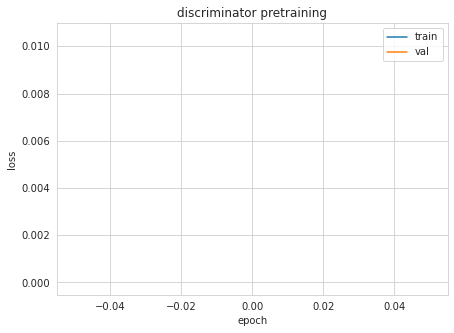

In [24]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [25]:
# save_path = 'saved_models/pretrained_dis2.pth'
# torch.save(D.state_dict(), save_path)

### 6. adversarial training

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [28]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis2.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [29]:
n_epochs = 1

In [30]:
writer = SummaryWriter()

In [31]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [32]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(generated_highlight).squeeze(1)
        rewards = 1 - rewards
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        pg_loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss/gen_pg_train', pg_loss.data.item(), iter_num)
        total_G_loss += pg_loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(generated_highlight).squeeze(1)
        rewards = 1 - rewards
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        total_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Loss/gen_pg_val', total_loss / len(val_dataset), iter_num)
    
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out, sp)[ind]}')
    print(f'truth: {tensor_to_text(highlight, sp)[ind]}')

539it [02:21,  3.80it/s]
0it [00:00, ?it/s]

epoch 0 G loss: 62.34072942346092
epoch 0 D loss: 0.002295435727957926


231it [00:23,  9.89it/s]
231it [00:13, 17.22it/s]

epoch 0 val loss: 6.240956735741797
predicted: uae deports 36 yr old kashmiri over suspected links isis
truth: uae deports indian over suspected links with isis


In [49]:
#save_path = 'saved_models/dis2_adv.pth'
#torch.save(D.state_dict(), save_path)

#save_path = 'saved_models/gen_adv.pth'
#torch.save(G.state_dict(), save_path)